<a href="https://colab.research.google.com/github/eddiechn/CatOrDog/blob/main/Cat_or_Dog%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setup and load data


**1.1 Install Dependencies and Setup**

In [2]:
pip install tensorflow opencv-python matplotlib

ERROR: Operation cancelled by user


In [3]:
import tensorflow as tf
import os

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# limiting memory growth
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
if not os.path.exists('data'):
  os.mkdir('data')

for animal in os.listdir('drive/MyDrive'):
  if animal.endswith('zip'):
    destination = animal[:-4]
    !unzip -q -o drive/MyDrive/$animal -d data/$destination


**1.2 Remove dodgy images**
ex : invalid extension

In [7]:
import cv2
import imghdr

In [8]:
data_dir = 'data'

In [9]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [10]:
os.listdir(data_dir)

['dog', 'cat']

In [11]:
for imageclass in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir, imageclass)):
    image_path = os.path.join(data_dir, imageclass, image)

    try:

      img = cv2.imread(image_path)
      if img is None:
        os.remove(image_path)
        print(f"unable to load image using OpenCV : {image_path}")

      tip = imghdr.what(image_path)
      if tip not in image_exts:
        os.remove(image_path)
        print(f"image extension not supported : {image_path}")

    except Exception as e:
      print('Issue with image', image_path, ':', e)

image extension not supported : data/dog/chibi-funny-cute-dogs-puppy-600nw-2341426413.jpg
unable to load image using OpenCV : data/dog/vector3.svg
Issue with image data/dog/vector3.svg : [Errno 2] No such file or directory: 'data/dog/vector3.svg'
image extension not supported : data/dog/800px-Wilde_huendin_am_stillen.jpg
unable to load image using OpenCV : data/dog/vector6.svg
Issue with image data/dog/vector6.svg : [Errno 2] No such file or directory: 'data/dog/vector6.svg'
unable to load image using OpenCV : data/dog/vector9.svg
Issue with image data/dog/vector9.svg : [Errno 2] No such file or directory: 'data/dog/vector9.svg'
image extension not supported : data/dog/dachshund-dog.jpg
image extension not supported : data/dog/dog-breed-height-comparison.jpg
unable to load image using OpenCV : data/dog/vector4.svg
Issue with image data/dog/vector4.svg : [Errno 2] No such file or directory: 'data/dog/vector4.svg'
unable to load image using OpenCV : data/dog/vector11.svg
Issue with image

1.3 Load Data

In [12]:
import numpy as np
from matplotlib import pyplot as plt

In [13]:
data = tf.keras.utils.image_dataset_from_directory('data') # building data using keras. some preprocessign already

Found 250 files belonging to 2 classes.


In [15]:
data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [16]:
data_iterator = data.as_numpy_iterator() # accessing data through batches

In [17]:
# move forward
batch = data_iterator.next()

In [18]:
# CLASS 1 = Dog
# CLASS 0 = Cat
batch[1]

array([1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0], dtype=int32)

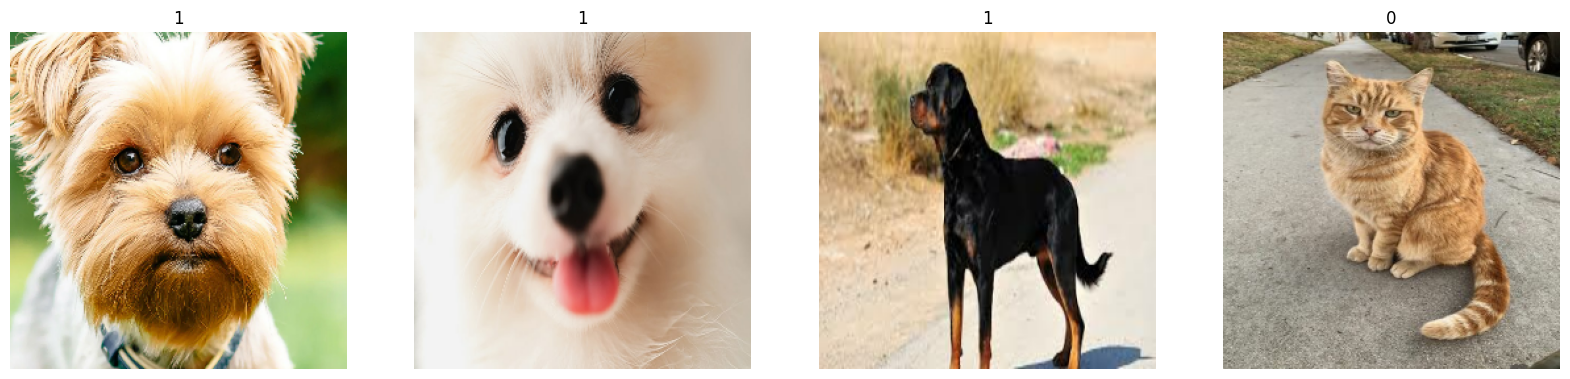

In [19]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))

for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])
  ax[idx].axis('off')

# 2. Preprocessing data

In [20]:
batch[0].max()

255.0

In [21]:
scaled = batch[0]/255 # ensure that no single feature dominates the distance calculations in an algorithm
scaled.max(), scaled.min()

(1.0, 0.0)

In [22]:
data = data.map(lambda x,y: (x/255, y))

In [23]:
data.as_numpy_iterator().next()[0].max()

1.0

In [24]:
len(data)

8

In [25]:
train_size = int(len(data)*.7)
test_size = int(len(data)*.2) +1
val_size = int(len(data)*.1) +1

In [26]:
train = data.take(train_size)
test = data.skip(train_size).take(test_size)
val = data.skip(train_size+test_size).take(val_size)

In [27]:
len(val), len(test), len(train)

(1, 2, 5)

# 3. Deep Model

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [29]:
model = Sequential()

In [30]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [31]:
model.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

In [33]:
logdir = 'logs'

In [34]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [35]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
5/5 [==============================] - 17s 1s/step - loss: 0.9794 - accuracy: 0.5562 - val_loss: 0.7044 - val_accuracy: 0.5769
Epoch 2/20
5/5 [==============================] - 11s 2s/step - loss: 0.7311 - accuracy: 0.4563 - val_loss: 0.6761 - val_accuracy: 0.5769
Epoch 3/20
5/5 [==============================] - 10s 1s/step - loss: 0.6659 - accuracy: 0.5750 - val_loss: 0.6106 - val_accuracy: 0.6154
Epoch 4/20
5/5 [==============================] - 10s 1s/step - loss: 0.6340 - accuracy: 0.6375 - val_loss: 0.5549 - val_accuracy: 0.7692
Epoch 5/20
5/5 [==============================] - 11s 1s/step - loss: 0.6256 - accuracy: 0.6687 - val_loss: 0.7290 - val_accuracy: 0.3846
Epoch 6/20
5/5 [==============================] - 10s 2s/step - loss: 0.5998 - accuracy: 0.6500 - val_loss: 0.4319 - val_accuracy: 0.8846
Epoch 7/20
5/5 [==============================] - 10s 1s/step - loss: 0.5310 - accuracy: 0.7625 - val_loss: 0.5046 - val_accuracy: 0.7692
Epoch 8/20
5/5 [==================

In [36]:
hist.history

{'loss': [0.9794042706489563,
  0.7310665845870972,
  0.665898859500885,
  0.6339618563652039,
  0.6256111860275269,
  0.5998072624206543,
  0.531006932258606,
  0.4905014634132385,
  0.44415655732154846,
  0.3655272126197815,
  0.30911993980407715,
  0.2730024456977844,
  0.23058323562145233,
  0.19076837599277496,
  0.17796650528907776,
  0.17704081535339355,
  0.1274290382862091,
  0.06769667565822601,
  0.09720096737146378,
  0.06119588017463684],
 'accuracy': [0.5562499761581421,
  0.45625001192092896,
  0.574999988079071,
  0.637499988079071,
  0.668749988079071,
  0.6499999761581421,
  0.762499988079071,
  0.8125,
  0.800000011920929,
  0.8687499761581421,
  0.8687499761581421,
  0.887499988079071,
  0.9312499761581421,
  0.9312499761581421,
  0.9624999761581421,
  0.956250011920929,
  0.9437500238418579,
  0.987500011920929,
  0.9624999761581421,
  0.9750000238418579],
 'val_loss': [0.704365074634552,
  0.6761408448219299,
  0.6106178760528564,
  0.5548564195632935,
  0.7290477

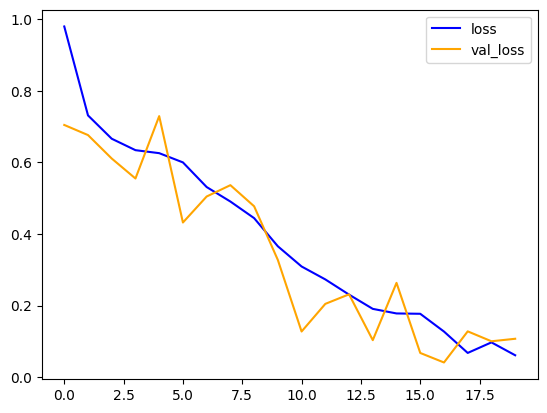

In [37]:
plot = plt.figure()
plt.plot(hist.history['loss'], color='blue', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
plt.legend()
plt.show()

# 4. Evaluate performace

In [38]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [40]:
precision = Precision()
recall = Recall()
binacc = BinaryAccuracy()

In [43]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    binacc.update_state(y, yhat)

1/1 [==============================] - 0s 28ms/step


In [44]:
print(f"Precision : {precision.result().numpy()}, Recall : {recall.result().numpy()}, Accuracy : {binacc.result().numpy()}")

Precision : 0.9142857193946838, Recall : 1.0, Accuracy : 0.953125


Test

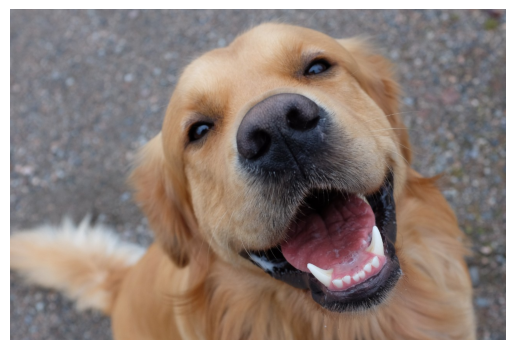

In [50]:
img = cv2.imread('dogtest.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(img)
plt.show()

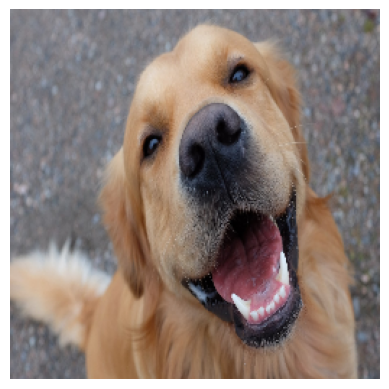

In [54]:
resized = tf.image.resize(img, (256, 256))
plt.imshow(resized.numpy().astype(int))
plt.axis('off')
plt.show()

In [55]:
yhat = model.predict(np.expand_dims(resized/255, 0))

1/1 [==============================] - 0s 244ms/step


In [56]:
yhat

array([[0.991379]], dtype=float32)

In [58]:
if yhat > 0.5:
  print("Animal detected is dog")
else :
    print("Animal detected is cat")

Animal detected is dog
